In [56]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [3]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [4]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.05
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


d = 60
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.519562,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.517648,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.515995,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.514920,1.0


In [5]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 60
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.519562,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.517648,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.515995,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.514920,1.0,0.494478,1.0


In [6]:

price_data['Close_60'] = price_data.groupby('Ticker')['Close'].shift(-60)
price_data['Smoothed_Close_60'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-60)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [7]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.923063,0.706194
5691,2024-10-28,12.810000,13.000000,12.780000,12.890000,12.643094,20050900,ABEV3.SA,0.060000,12.885358,NaN,12.890000,NaN,NaN,NaN
5692,2024-10-29,12.900000,13.030000,12.870000,12.980000,12.731369,21500600,ABEV3.SA,0.089999,12.890090,NaN,12.980000,NaN,NaN,NaN
5693,2024-10-30,13.050000,13.090000,12.900000,12.930000,12.682327,21176300,ABEV3.SA,-0.049999,12.892085,NaN,12.930000,NaN,NaN,NaN
5694,2024-10-31,12.600000,12.840000,12.480000,12.640000,12.397882,61215800,ABEV3.SA,-0.290000,12.879481,NaN,12.640000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [8]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [9]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,98.814751
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,112.164843
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,108.559363
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,106.114818
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,103.626756


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [10]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,98.814751,-1.185249
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,112.164843,12.164843
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,108.559363,8.559363
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,106.114818,6.114818
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,103.626756,3.626756


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [11]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,98.814751,-1.185249,-1.014420,-0.950416
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,112.164843,12.164843,-1.005583,-0.961449
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,108.559363,8.559363,-0.997612,-0.968682
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,106.114818,6.114818,-0.987057,-0.972357
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,103.626756,3.626756,-0.974724,-0.972830


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [12]:
# Período do indicador
e = 27

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,98.814751,-1.185249,-1.014420,-0.950416,-0.070052
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,112.164843,12.164843,-1.005583,-0.961449,-0.072519
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,108.559363,8.559363,-0.997612,-0.968682,-0.074422
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,106.114818,6.114818,-0.987057,-0.972357,-0.073965
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,103.626756,3.626756,-0.974724,-0.972830,-0.072962


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [13]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,55.049862,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,98.814751,-1.185249,-1.014420,-0.950416,-0.070052,3159612880
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,54.930369,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,112.164843,12.164843,-1.005583,-0.961449,-0.072519,3124967480
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,54.799851,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,108.559363,8.559363,-0.997612,-0.968682,-0.074422,3099870180
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,54.711358,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,106.114818,6.114818,-0.987057,-0.972357,-0.073965,3079349580
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,54.621290,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,103.626756,3.626756,-0.974724,-0.972830,-0.072962,3078096980


#### Salvando antes de tirar os Nans.

In [14]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [18]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [15]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26609 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11719,2024-10-21,61.349998,61.380001,60.270000,60.330002,59.796291,19044900,VALE3.SA,-0.219997,60.598574,-1.0,60.330002,-1.0,54.020000,55.049862,0.219997,0.000000,39.561996,60.250000,65.349998,6.834786,-93.165214,0.391453,0.312635,0.036498,4210887480
11720,2024-10-22,60.150002,60.660000,59.900002,60.410000,59.875580,14814000,VALE3.SA,0.079998,60.589145,-1.0,60.410000,-1.0,52.660000,54.930369,0.000000,0.079998,40.591420,59.900002,63.799999,17.670363,-82.329637,0.384274,0.326963,0.036305,4196073480
11721,2024-10-23,59.889999,59.900002,59.150002,59.349998,58.824959,18289900,VALE3.SA,-1.060001,60.527188,-1.0,59.349998,-1.0,52.320000,54.799851,1.060001,0.000000,32.204911,59.150002,63.740002,30.004060,-69.995940,0.369328,0.335436,0.035216,4177783580
11722,2024-10-24,59.340000,59.700001,59.209999,59.700001,59.171864,11331700,VALE3.SA,0.350002,60.485829,-1.0,59.700001,-1.0,53.029999,54.711358,0.000000,0.350002,37.152011,59.150002,63.740002,29.102985,-70.897015,0.350109,0.338370,0.034728,4166451880
11723,2024-10-25,60.570000,62.470001,60.520000,61.730000,61.183903,38466000,VALE3.SA,2.029999,60.548037,-1.0,61.730000,-1.0,52.910000,54.621290,0.000000,2.029999,57.773192,59.150002,62.520000,41.484749,-58.515251,0.336025,0.337901,0.036604,4204917880


## VALIDAÇÃO

### Geral

In [16]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 310, oob_score = True, criterion = "gini", random_state = 0, n_jobs=-1)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  85.4802344806854


In [17]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 79.39%


In [18]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [19]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5686,2024-10-17,12.78,12.96,12.75,12.86,12.613667,18266900,ABEV3.SA,-0.08,12.895616,-1.0,12.86,-1.0,11.25,12.036778,0.08,0.00,36.610573,12.72,13.85,15.541249,-84.458751,0.144057,0.154677,0.038533,-2239069075,1
5687,2024-10-18,12.96,12.96,12.80,12.88,12.633285,19422900,ABEV3.SA,0.02,12.894836,-1.0,12.88,-1.0,11.02,11.985939,0.00,0.02,38.324338,12.75,13.85,13.166867,-86.833133,0.138341,0.151409,0.036871,-2258491975,1
5688,2024-10-21,12.88,12.94,12.81,12.83,12.584243,28877400,ABEV3.SA,-0.05,12.891594,-1.0,12.83,-1.0,11.05,11.939142,0.05,0.00,35.551811,12.75,13.85,12.872159,-87.127841,0.132026,0.147533,0.034391,-2287369375,1
5689,2024-10-22,12.77,12.90,12.73,12.82,12.574433,34756100,ABEV3.SA,-0.01,12.888014,-1.0,12.82,-1.0,10.87,11.885685,0.01,0.00,34.968018,12.73,13.85,14.108432,-85.891568,0.125289,0.143084,0.031427,-2322125475,1
5690,2024-10-24,12.72,12.89,12.68,12.83,12.584243,19295300,ABEV3.SA,0.01,12.885113,-1.0,12.83,-1.0,10.91,11.836901,0.00,0.01,36.177279,12.68,13.85,17.531031,-82.468969,0.118352,0.138138,0.028131,-2341420775,1


In [20]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.5890
  Accuracy with Verify: 0.5508
Fold 2:
  Accuracy with Y_test (Prediction): 0.6229
  Accuracy with Verify: 0.6886
Fold 3:
  Accuracy with Y_test (Prediction): 0.6123
  Accuracy with Verify: 0.5731
Fold 4:
  Accuracy with Y_test (Prediction): 0.6017
  Accuracy with Verify: 0.4693
Fold 5:
  Accuracy with Y_test (Prediction): 0.5879
  Accuracy with Verify: 0.4809

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.6028
  Média da acurácia com Verify: 0.5525


#### Walk-Forward Validation

In [21]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4222
  Accuracy with Verify: 0.3333
Window 2:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.7778
Window 3:
  Accuracy with Y_test (Prediction): 0.8389
  Accuracy with Verify: 0.6611
Window 4:
  Accuracy with Y_test (Prediction): 0.5500
  Accuracy with Verify: 0.7222
Window 5:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.5944
Window 6:
  Accuracy with Y_test (Prediction): 0.4278
  Accuracy with Verify: 0.4167
Window 7:
  Accuracy with Y_test (Prediction): 0.3500
  Accuracy with Verify: 0.2167
Window 8:
  Accuracy with Y_test (Prediction): 0.9389
  Accuracy with Verify: 0.8056
Window 9:
  Accuracy with Y_test (Prediction): 0.1667
  Accuracy with Verify: 0.1056
Window 10:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.5000
Window 11:
  Accuracy with Y_test (Prediction): 0.4056
  Accuracy with Verify: 0.2167
Window 12:
  Accuracy with Y_test (Prediction): 0.6000
  Accura

#### Split normal sem cross-validation.

In [23]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

Acurácia com Y_test (Prediction): 0.8842
Acurácia com Verify: 0.7126

Métricas para 'Prediction':
  Acurácia: 0.8842
  Precisão: 0.8912
  Recall: 0.9342
  F1-Score: 0.9122
  Specificidade: 0.7937

Métricas para 'Verify':
  Acurácia: 0.7126
  Precisão: 0.7437
  Recall: 0.8144
  F1-Score: 0.7775
  Specificidade: 0.5488


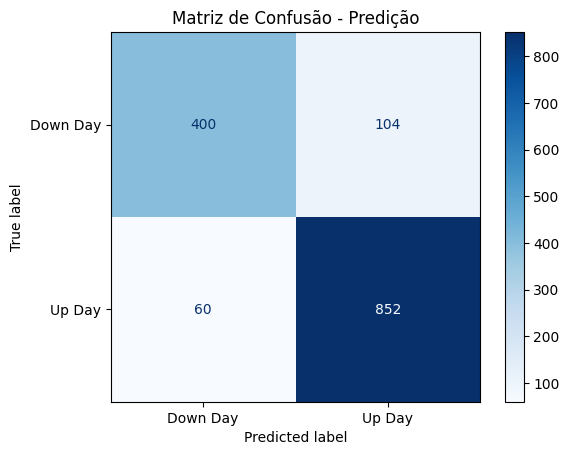

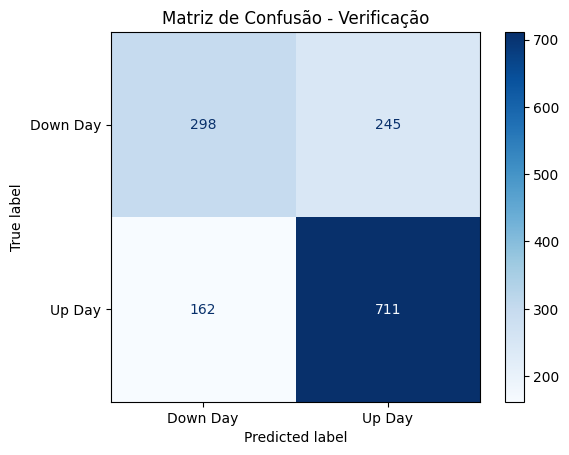

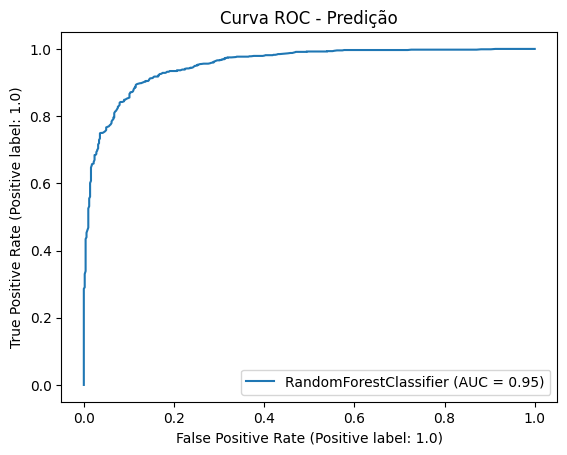

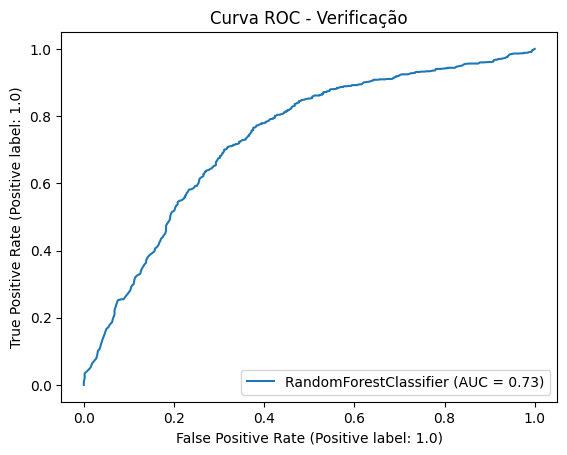

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_ABEV['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Ambev.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Ambev.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [84]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [25]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 76.98%

Precisão do modelo nos últimos 30 dias: 84.21%


#### Plotagem:

In [26]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

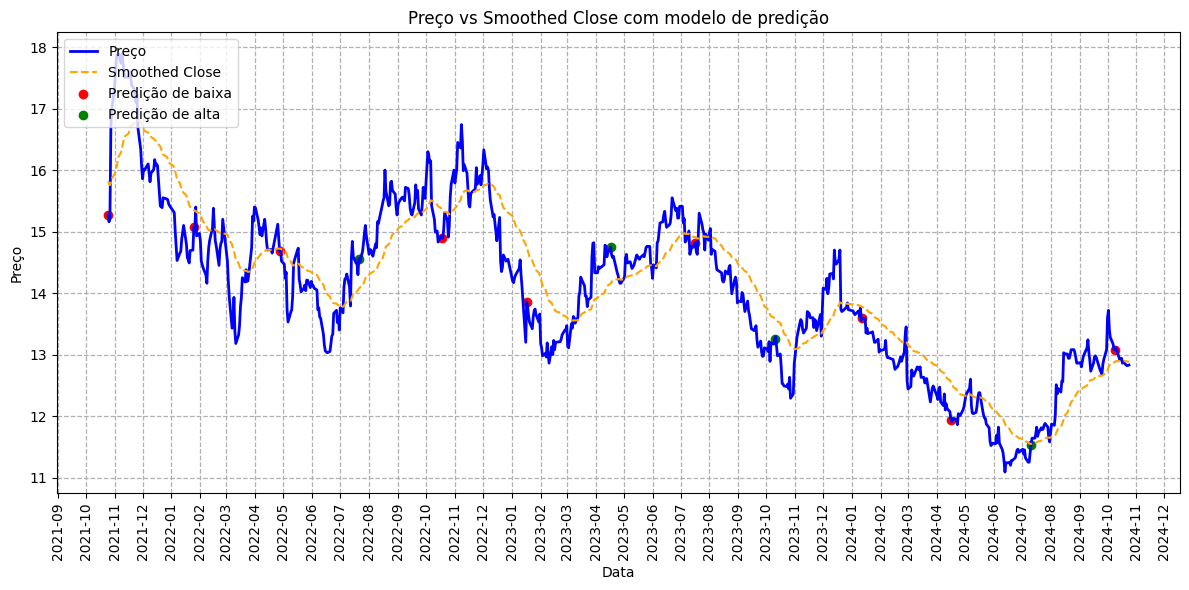

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=1095)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 60):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [28]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17892,2001-02-02,3.030096,3.046653,2.988701,3.046653,1.747820,33832788,ITUB4.SA,0.016557,3.071692,-1.0,3.046653,-1.0,3.046653,2.818954,0.000000,0.016557,40.163704,2.988701,3.377811,21.328340,-78.671660,0.019280,0.017242,0.037540,1548802436,1
17893,2001-02-05,3.030096,3.030096,2.963864,2.972143,1.705074,11958036,ITUB4.SA,-0.074510,3.066714,-1.0,2.972143,1.0,3.030096,2.829511,0.074510,0.000000,32.402356,2.963864,3.377811,24.846243,-75.153757,0.018279,0.017449,0.038109,1536844400,0
17894,2001-02-06,2.996980,3.005259,2.980422,3.005259,1.724071,36043213,ITUB4.SA,0.033116,3.063642,-1.0,3.005259,-1.0,2.930748,2.834573,0.000000,0.033116,38.497298,2.963864,3.377811,24.103934,-75.896066,0.017062,0.017372,0.039227,1500801187,1
17895,2001-02-07,2.996814,2.996814,2.930748,2.947306,1.690827,61444982,ITUB4.SA,-0.057953,3.057825,-1.0,2.947306,1.0,2.996980,2.842693,0.057953,0.000000,32.567869,2.930748,3.377811,28.424810,-71.575190,0.015489,0.016995,0.037616,1439356205,0
17896,2001-02-08,2.978766,3.071490,2.978766,3.029764,1.738130,54137293,ITUB4.SA,0.082458,3.056422,-1.0,3.029764,-1.0,2.914190,2.846268,0.000000,0.082458,46.177604,2.930748,3.377811,28.110975,-71.889025,0.013977,0.016392,0.035099,1385218912,1


In [29]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=410 , oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5990
  Accuracy with Verify: 0.5083
Fold 2:
  Accuracy with Y_test (Prediction): 0.5646
  Accuracy with Verify: 0.5000
Fold 3:
  Accuracy with Y_test (Prediction): 0.6948
  Accuracy with Verify: 0.5948
Fold 4:
  Accuracy with Y_test (Prediction): 0.5490
  Accuracy with Verify: 0.4740
Fold 5:
  Accuracy with Y_test (Prediction): 0.7396
  Accuracy with Verify: 0.6333

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.6294
  Média da acurácia com Verify: 0.5421

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0    -1.0
1            1.0              1.0    -1.0
2            1.0              1.0    -1.0
3            1.0              1.0    -1.0
4            1.0              1.0    -1.0
...          ...              ...     ...
4795        -1.0             -1.0    -1.0
4796        -1.0             -1.0    -1.0
4797        -1.0             -1.0    -1.0
4798        -1.0             -1.0    -

#### Walk-Forward Validation

In [30]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4944
  Accuracy with Verify: 0.4667
Window 2:
  Accuracy with Y_test (Prediction): 0.5167
  Accuracy with Verify: 0.4000
Window 3:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.7167
Window 4:
  Accuracy with Y_test (Prediction): 0.5556
  Accuracy with Verify: 0.5611
Window 5:
  Accuracy with Y_test (Prediction): 0.7222
  Accuracy with Verify: 0.8000
Window 6:
  Accuracy with Y_test (Prediction): 0.7556
  Accuracy with Verify: 0.7000
Window 7:
  Accuracy with Y_test (Prediction): 0.3111
  Accuracy with Verify: 0.1000
Window 8:
  Accuracy with Y_test (Prediction): 0.4667
  Accuracy with Verify: 0.4278
Window 9:
  Accuracy with Y_test (Prediction): 0.4333
  Accuracy with Verify: 0.4667
Window 10:
  Accuracy with Y_test (Prediction): 0.1722
  Accuracy with Verify: 0.2611
Window 11:
  Accuracy with Y_test (Prediction): 0.5444
  Accuracy with Verify: 0.5167
Window 12:
  Accuracy with Y_test (Prediction): 0.3389
  Accura

#### Split normal sem cross-validation.

In [32]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

Acurácia com Y_test (Prediction): 0.9118
Acurácia com Verify: 0.7319

Métricas para 'Prediction':
  Acurácia: 0.9118
  Precisão: 0.9238
  Recall: 0.9371
  F1-Score: 0.9304
  Specificidade: 0.8689

Métricas para 'Verify':
  Acurácia: 0.7319
  Precisão: 0.7617
  Recall: 0.8074
  F1-Score: 0.7839
  Specificidade: 0.6178


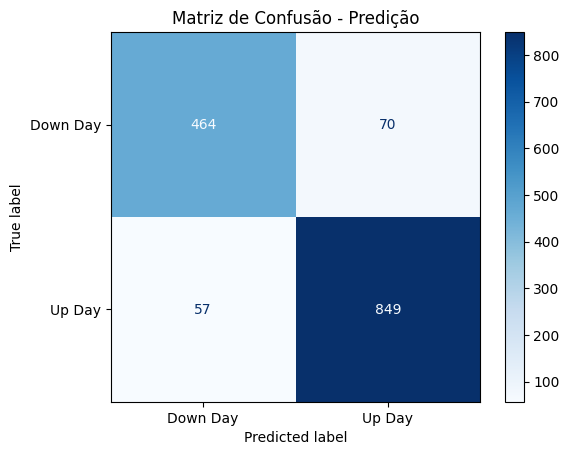

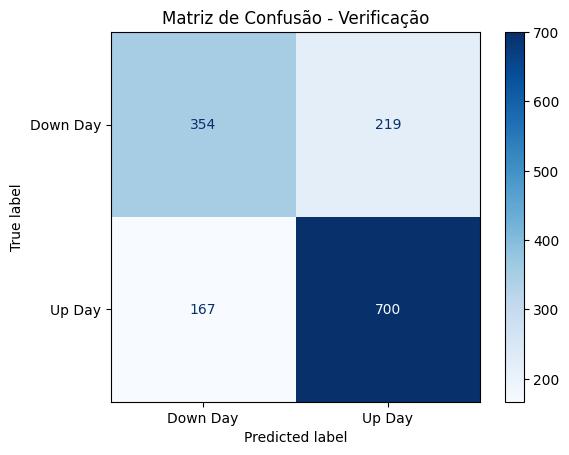

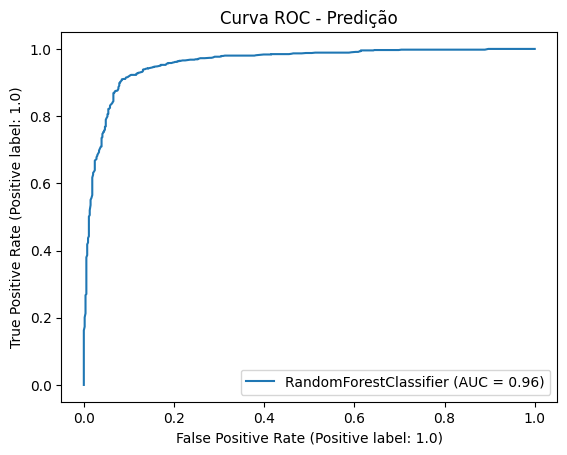

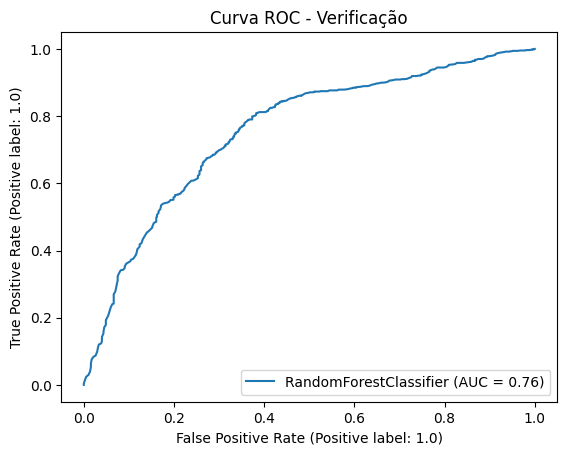

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Itau['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Itau.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Itau.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para ITAU.

In [247]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [105]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 77.29%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [34]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

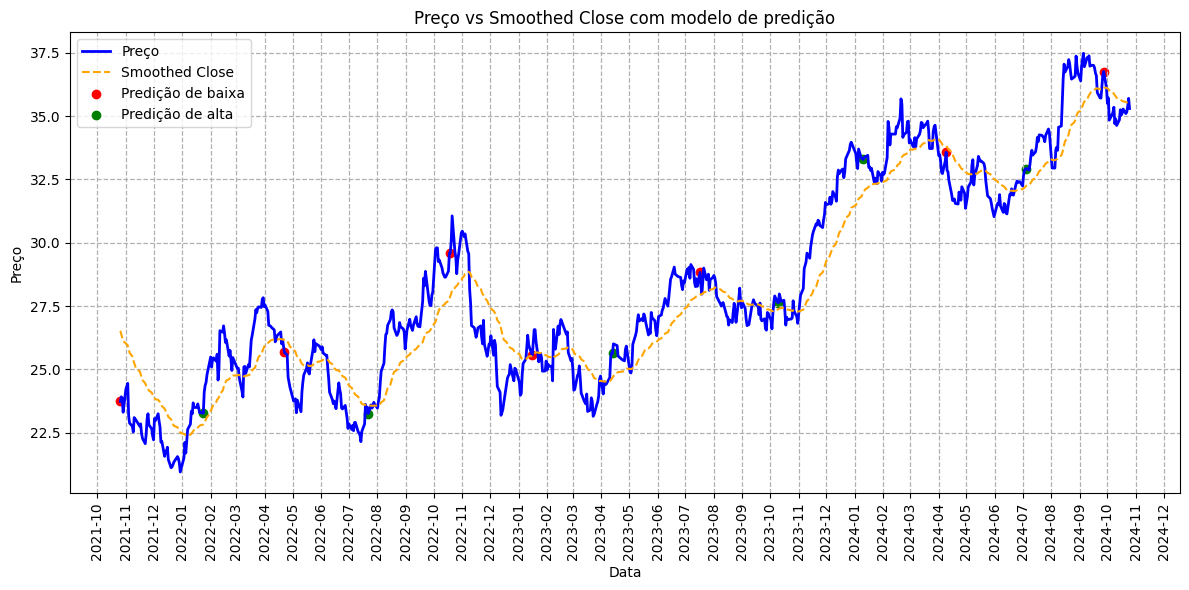

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=1095)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 60):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [36]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23739,2011-06-10,4.954290,5.012748,4.857835,5.012748,4.616810,1587130,MGLU3.SA,0.014614,4.776745,-1.0,5.012748,-1.0,4.132960,3.965549,0.000000,0.014614,78.417478,4.436940,5.047823,55.625186,-44.374814,-0.003825,-0.009608,-0.006531,-13419150,1
23740,2011-06-13,5.012748,5.191044,4.998134,5.056591,4.657189,2819132,MGLU3.SA,0.043843,4.790737,1.0,5.056591,-1.0,4.293718,3.981957,0.000000,0.043843,80.938249,4.436940,5.191044,46.916226,-53.083774,-0.000629,-0.007812,-0.003166,-10600018,0
23741,2011-06-14,5.085820,5.129663,4.872450,5.003979,4.608733,2110243,MGLU3.SA,-0.052612,4.801399,-1.0,5.003979,-1.0,4.264489,3.996084,0.052612,0.000000,69.671141,4.436940,5.191044,48.330103,-51.669897,0.002647,-0.005721,-0.001062,-8489775,1
23742,2011-06-15,4.998134,4.998134,4.887064,4.936753,4.546816,1644265,MGLU3.SA,-0.067226,4.808167,-1.0,4.936753,-1.0,4.208955,4.006727,0.067226,0.000000,57.806837,4.536318,5.191044,41.521050,-58.478950,0.005671,-0.003442,0.000542,-6845510,1
23743,2011-06-16,4.822760,4.930907,4.673693,4.910447,4.522589,2052423,MGLU3.SA,-0.026306,4.813281,-1.0,4.910447,-1.0,4.252798,4.019031,0.026306,0.000000,53.679629,4.559701,5.191044,40.165177,-59.834823,0.008344,-0.001085,0.002159,-4793087,1


In [37]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5278
  Accuracy with Verify: 0.4796
Fold 2:
  Accuracy with Y_test (Prediction): 0.6926
  Accuracy with Verify: 0.6463
Fold 3:
  Accuracy with Y_test (Prediction): 0.8556
  Accuracy with Verify: 0.8148
Fold 4:
  Accuracy with Y_test (Prediction): 0.2370
  Accuracy with Verify: 0.3111
Fold 5:
  Accuracy with Y_test (Prediction): 0.4963
  Accuracy with Verify: 0.3315

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5619
  Média da acurácia com Verify: 0.5167

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0    -1.0
2            1.0              1.0    -1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
2695         1.0             -1.0    -1.0
2696         1.0             -1.0    -1.0
2697         1.0              1.0    -1.0
2698         1.0             -1.0    -

#### Walk-Forward Validation

In [38]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4500
  Accuracy with Verify: 0.5389
Window 2:
  Accuracy with Y_test (Prediction): 0.6611
  Accuracy with Verify: 0.6000
Window 3:
  Accuracy with Y_test (Prediction): 0.7833
  Accuracy with Verify: 0.7389
Window 4:
  Accuracy with Y_test (Prediction): 0.3889
  Accuracy with Verify: 0.5056
Window 5:
  Accuracy with Y_test (Prediction): 0.7611
  Accuracy with Verify: 0.7611
Window 6:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 1.0000
Window 7:
  Accuracy with Y_test (Prediction): 0.9500
  Accuracy with Verify: 0.8444
Window 8:
  Accuracy with Y_test (Prediction): 0.9833
  Accuracy with Verify: 0.9167
Window 9:
  Accuracy with Y_test (Prediction): 0.9278
  Accuracy with Verify: 0.8889
Window 10:
  Accuracy with Y_test (Prediction): 0.7278
  Accuracy with Verify: 0.7000
Window 11:
  Accuracy with Y_test (Prediction): 0.0778
  Accuracy with Verify: 0.1444
Window 12:
  Accuracy with Y_test (Prediction): 0.3111
  Accura

#### Split normal sem cross-validation.

In [40]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

Acurácia com Y_test (Prediction): 0.9372
Acurácia com Verify: 0.7968

Métricas para 'Prediction':
  Acurácia: 0.9372
  Precisão: 0.9568
  Recall: 0.9236
  F1-Score: 0.9399
  Specificidade: 0.9526

Métricas para 'Verify':
  Acurácia: 0.7968
  Precisão: 0.8106
  Recall: 0.7972
  F1-Score: 0.8038
  Specificidade: 0.7964


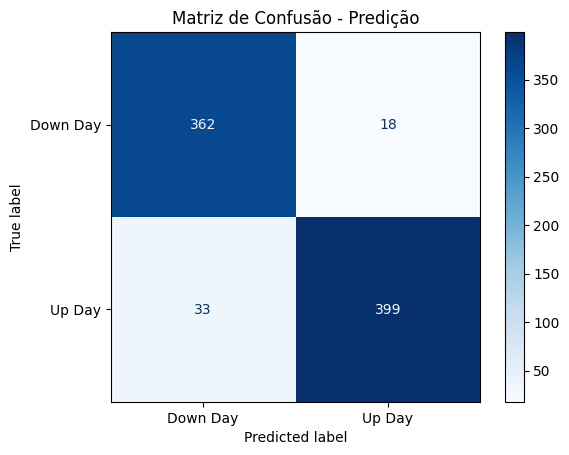

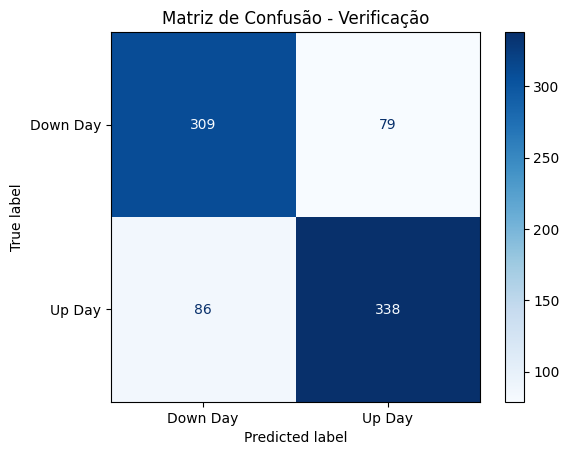

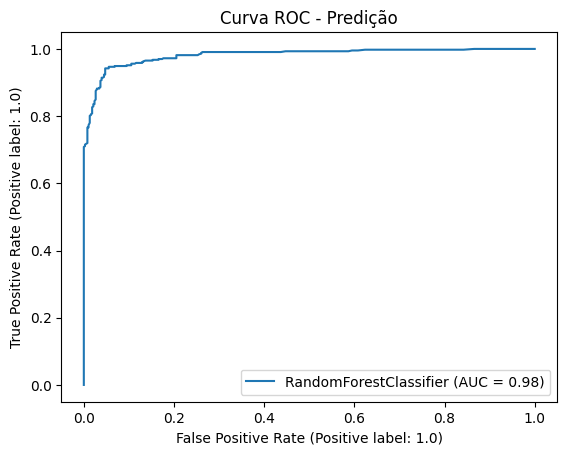

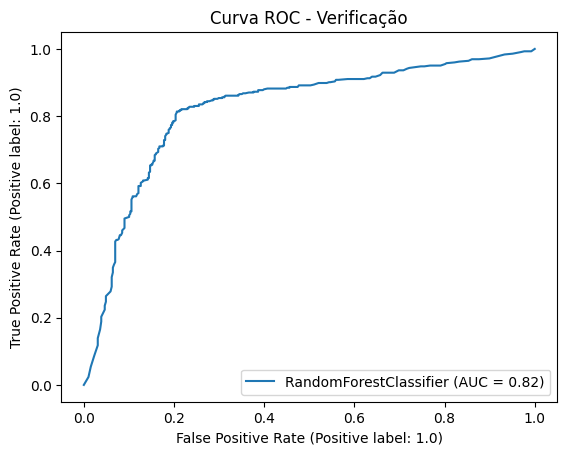

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Magalu['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Magalu.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Magalu.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [87]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [117]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 82.34%

Precisão do modelo nos últimos 30 dias: 90.00%


#### Plotagem:

In [42]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

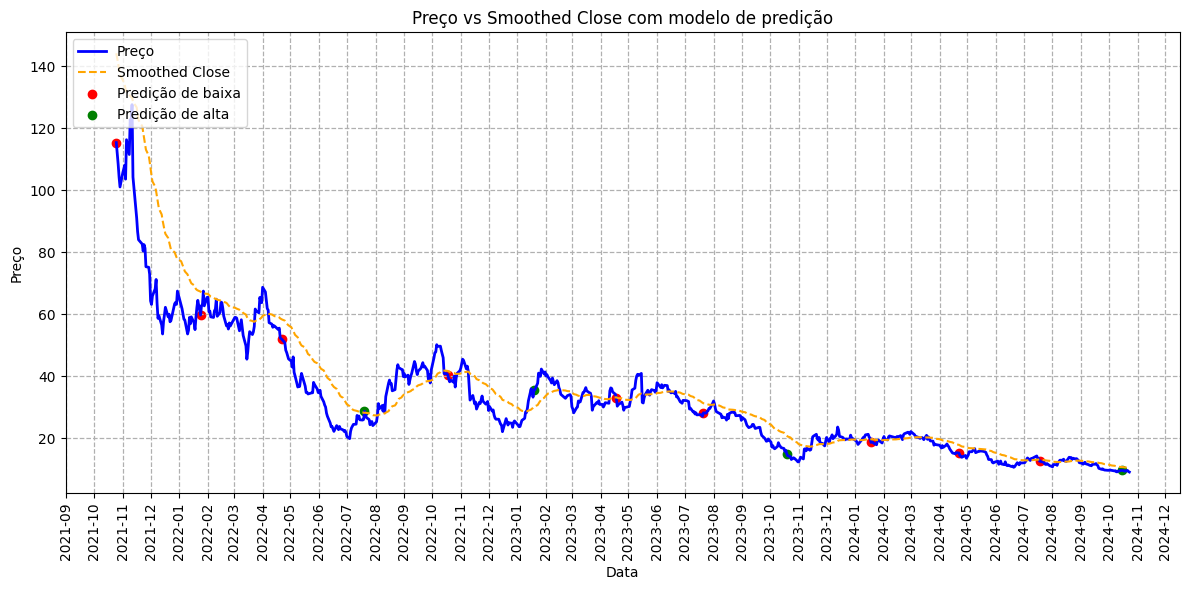

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=1095)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Magalu.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 60):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [44]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17800,2024-10-21,37.000000,37.049999,36.200001,36.250000,33.607883,28390000,PETR4.SA,-0.580002,37.297534,1.0,36.250000,1.0,37.299999,37.304716,0.580002,0.000000,29.172059,36.200001,38.380001,50.345564,-49.654436,-0.070696,-0.081906,-0.015952,-57427325995,1
17801,2024-10-22,36.200001,36.299999,35.990002,36.110001,33.478088,29144300,PETR4.SA,-0.139999,37.238158,1.0,36.110001,1.0,37.090000,37.293980,0.139999,0.000000,27.359614,35.990002,38.380001,52.224108,-47.775892,-0.076446,-0.080814,-0.015958,-57456470295,1
17802,2024-10-23,35.910000,35.939999,35.570000,35.660000,33.060886,30769100,PETR4.SA,-0.450001,37.159250,1.0,35.660000,1.0,36.830002,37.270782,0.450001,0.000000,22.235877,35.570000,38.380001,56.556910,-43.443090,-0.086374,-0.081926,-0.017222,-57487239395,1
17803,2024-10-24,35.849998,36.029999,35.560001,35.900002,33.283398,23058900,PETR4.SA,0.240002,37.096287,1.0,35.900002,1.0,36.639999,37.239242,0.000000,0.240002,30.271775,35.560001,38.380001,54.478228,-45.521772,-0.098191,-0.085179,-0.017887,-57510298295,1
17804,2024-10-25,35.959999,36.490002,35.849998,36.150002,33.515171,32585900,PETR4.SA,0.250000,37.048973,1.0,36.150002,1.0,36.810001,37.217780,0.000000,0.250000,37.975363,35.560001,37.900002,63.631260,-36.368740,-0.110105,-0.090164,-0.017029,-57542884195,1


In [45]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6376
  Accuracy with Verify: 0.5586
Fold 2:
  Accuracy with Y_test (Prediction): 0.5085
  Accuracy with Verify: 0.4665
Fold 3:
  Accuracy with Y_test (Prediction): 0.5656
  Accuracy with Verify: 0.5375
Fold 4:
  Accuracy with Y_test (Prediction): 0.5916
  Accuracy with Verify: 0.5335
Fold 5:
  Accuracy with Y_test (Prediction): 0.4975
  Accuracy with Verify: 0.4304

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5602
  Média da acurácia com Verify: 0.5053

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1            1.0             -1.0    -1.0
2            1.0             -1.0    -1.0
3            1.0             -1.0    -1.0
4            1.0             -1.0    -1.0
...          ...              ...     ...
4990        -1.0              1.0     1.0
4991        -1.0              1.0     1.0
4992        -1.0              1.0     1.0
4993        -1.0              1.0     

#### Walk-Forward Validation

In [46]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [47]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4611
  Accuracy with Verify: 0.4278
Window 2:
  Accuracy with Y_test (Prediction): 0.5944
  Accuracy with Verify: 0.6278
Window 3:
  Accuracy with Y_test (Prediction): 0.5556
  Accuracy with Verify: 0.5556
Window 4:
  Accuracy with Y_test (Prediction): 0.5056
  Accuracy with Verify: 0.3333
Window 5:
  Accuracy with Y_test (Prediction): 0.4833
  Accuracy with Verify: 0.3889
Window 6:
  Accuracy with Y_test (Prediction): 0.3500
  Accuracy with Verify: 0.3778
Window 7:
  Accuracy with Y_test (Prediction): 0.4556
  Accuracy with Verify: 0.4167
Window 8:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.6278
Window 9:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.5056
Window 10:
  Accuracy with Y_test (Prediction): 0.3056
  Accuracy with Verify: 0.3833
Window 11:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.6500
Window 12:
  Accuracy with Y_test (Prediction): 0.6000
  Accura

#### Split normal sem cross-validation.

In [48]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

Acurácia com Y_test (Prediction): 0.8953
Acurácia com Verify: 0.7198

Métricas para 'Prediction':
  Acurácia: 0.8953
  Precisão: 0.9020
  Recall: 0.9196
  F1-Score: 0.9107
  Specificidade: 0.8615

Métricas para 'Verify':
  Acurácia: 0.7198
  Precisão: 0.7387
  Recall: 0.7773
  F1-Score: 0.7575
  Specificidade: 0.6458


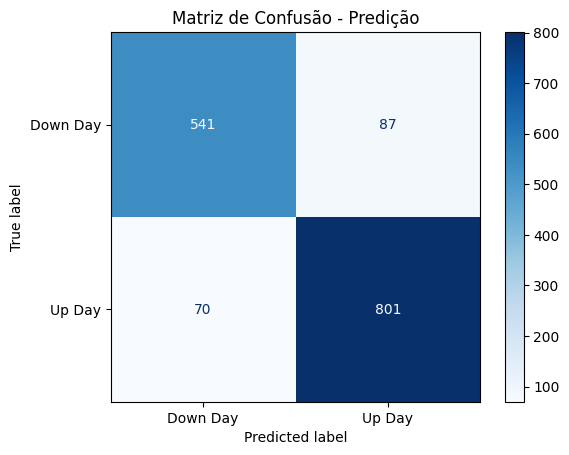

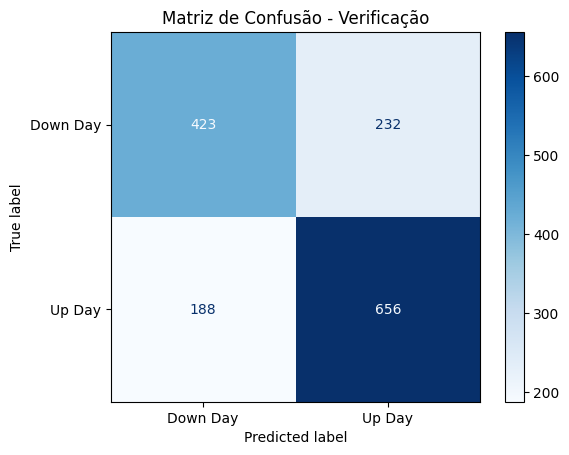

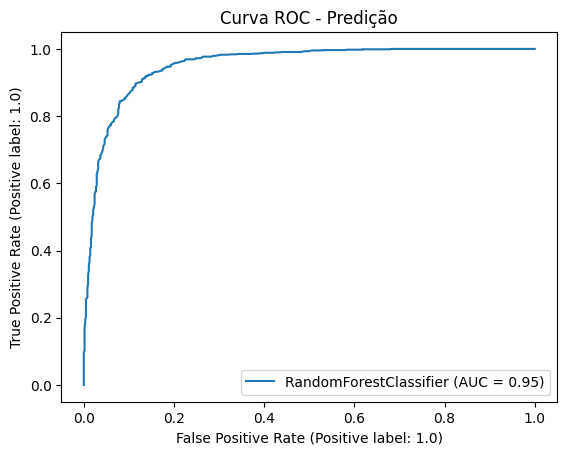

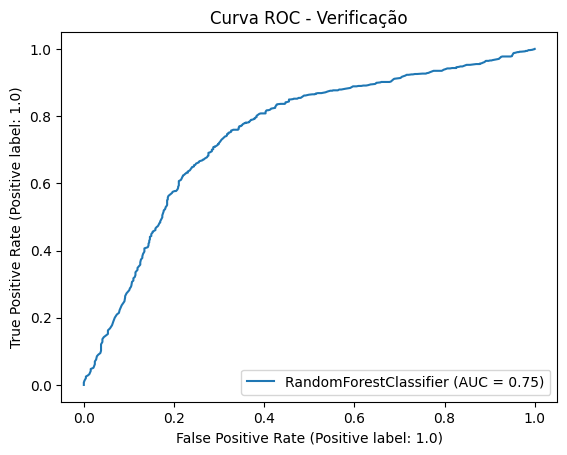

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Petro['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Petro.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Petro.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [100]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [129]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 77.29%

Precisão do modelo nos últimos 30 dias: 52.17%


#### Plotagem:

In [50]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

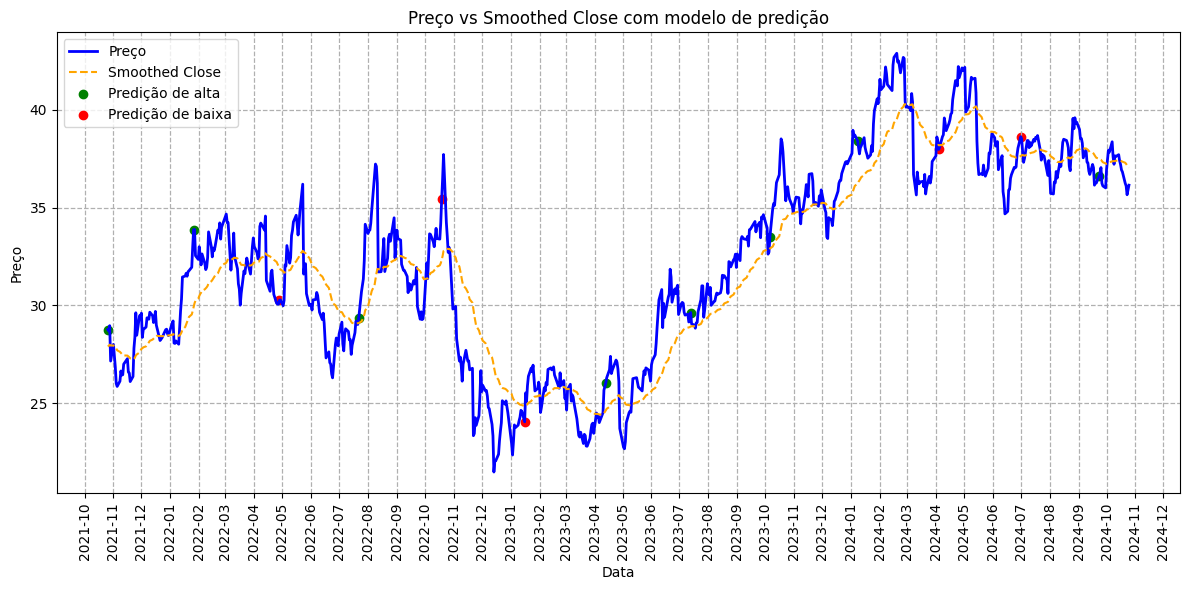

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=1095)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Petro.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 60):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [52]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_60,Smoothed_Close_60,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5778,2000-02-16,3.833333,3.833333,3.833333,3.833333,1.669120,470400,VALE3.SA,0.000000,3.814919,-1.0,3.833333,-1.0,3.291666,3.296878,0.000000,0.000000,44.253823,3.583333,4.366666,29.564227,-70.435773,0.043649,0.039944,0.089977,38889600,1
5779,2000-02-18,3.750000,3.750000,3.750000,3.750000,1.632835,28800,VALE3.SA,-0.083333,3.811673,-1.0,3.750000,-1.0,3.458333,3.304951,0.083333,0.000000,39.396182,3.583333,4.366666,29.149848,-70.850152,0.042425,0.040440,0.090348,38860800,1
5780,2000-02-22,3.666666,3.666666,3.666666,3.666666,1.596549,422400,VALE3.SA,-0.083334,3.804423,-1.0,3.666666,-1.0,3.485000,3.313954,0.083334,0.000000,34.967341,3.583333,4.366666,28.224269,-71.775731,0.040451,0.040442,0.089507,38438400,1
5781,2000-02-24,3.750000,3.750000,3.708333,3.708333,1.614692,340800,VALE3.SA,0.041667,3.799618,-1.0,3.708333,-1.0,3.508333,3.323672,0.000000,0.041667,38.928245,3.583333,4.366666,27.610928,-72.389072,0.038089,0.039972,0.087356,38097600,1
5782,2000-02-25,3.666666,3.666666,3.666666,3.666666,1.596549,38400,VALE3.SA,-0.041667,3.792971,-1.0,3.666666,-1.0,3.500000,3.332489,0.041667,0.000000,36.372135,3.583333,4.366666,26.762295,-73.237705,0.035313,0.039040,0.080214,38059200,1


In [53]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.4501
  Accuracy with Verify: 0.4450
Fold 2:
  Accuracy with Y_test (Prediction): 0.5086
  Accuracy with Verify: 0.4763
Fold 3:
  Accuracy with Y_test (Prediction): 0.4642
  Accuracy with Verify: 0.4551
Fold 4:
  Accuracy with Y_test (Prediction): 0.6882
  Accuracy with Verify: 0.5651
Fold 5:
  Accuracy with Y_test (Prediction): 0.6741
  Accuracy with Verify: 0.5651

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5570
  Média da acurácia com Verify: 0.5013

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1           -1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
4950         1.0             -1.0    -1.0
4951         1.0             -1.0    -1.0
4952         1.0             -1.0    -1.0
4953         1.0              1.0    -

#### Walk-Forward Validation

In [54]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.9278
  Accuracy with Verify: 0.9222
Window 2:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.5444
Window 3:
  Accuracy with Y_test (Prediction): 0.4000
  Accuracy with Verify: 0.5389
Window 4:
  Accuracy with Y_test (Prediction): 0.3056
  Accuracy with Verify: 0.2389
Window 5:
  Accuracy with Y_test (Prediction): 0.7278
  Accuracy with Verify: 0.6333
Window 6:
  Accuracy with Y_test (Prediction): 0.4222
  Accuracy with Verify: 0.4556
Window 7:
  Accuracy with Y_test (Prediction): 0.6167
  Accuracy with Verify: 0.6667
Window 8:
  Accuracy with Y_test (Prediction): 0.8722
  Accuracy with Verify: 0.7667
Window 9:
  Accuracy with Y_test (Prediction): 0.4778
  Accuracy with Verify: 0.4333
Window 10:
  Accuracy with Y_test (Prediction): 0.8667
  Accuracy with Verify: 0.6500
Window 11:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5889
Window 12:
  Accuracy with Y_test (Prediction): 0.5556
  Accura

#### Split normal sem cross-validation.

In [56]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

Acurácia com Y_test (Prediction): 0.8857
Acurácia com Verify: 0.7256

Métricas para 'Prediction':
  Acurácia: 0.8857
  Precisão: 0.8966
  Recall: 0.9090
  F1-Score: 0.9027
  Specificidade: 0.8530

Métricas para 'Verify':
  Acurácia: 0.7256
  Precisão: 0.7614
  Recall: 0.7719
  F1-Score: 0.7666
  Specificidade: 0.6607


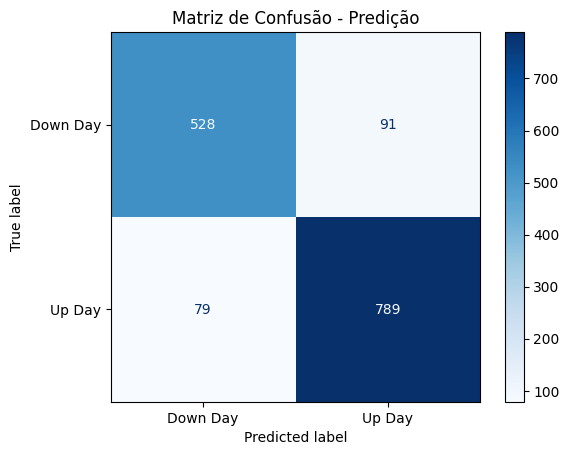

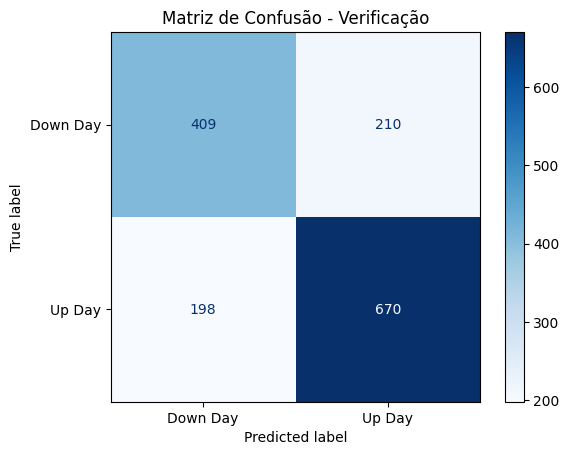

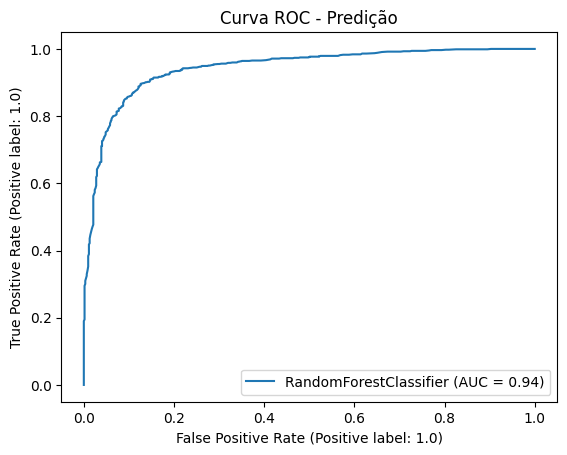

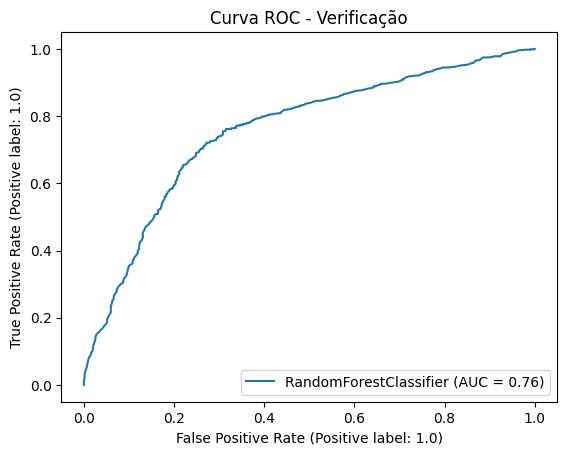

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Vale['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Vale.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Vale.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [113]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [141]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 77.93%

Precisão do modelo nos últimos 30 dias: 56.52%


#### Plotagem:

In [58]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

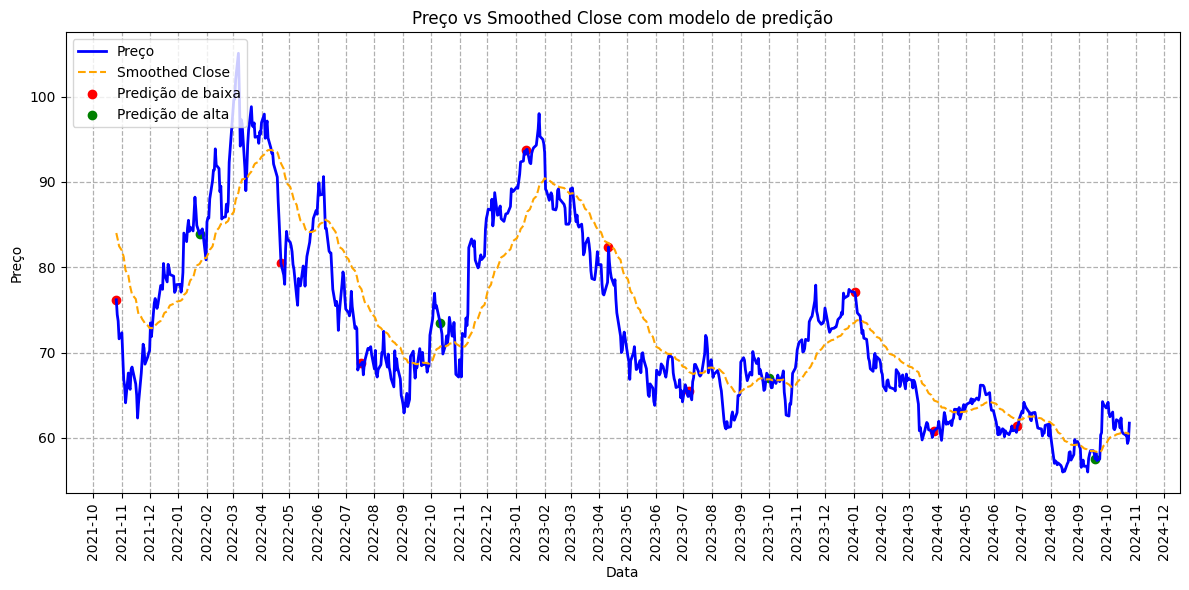

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=1095)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=410, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Vale.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 60):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
